<a href="https://colab.research.google.com/github/RafaelCaballero/BME/blob/main/mfia/10Normalidad_IC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<div class="alert alert-block alert-info">
<h1> Normalidad. Intervalos de confianza</h1>
</div>

### Rafa Caballero

# Tabla de Contenidos
1. [Introducción](#1.-Introducción)<br>
2. [Distribución Normal](#2.-Distribución-Normal)<br>
   2.1 [Definición](#2.1-Definición)<br>
   2.2 [Propiedades](#2.2-Propiedades)<br>
   2.3 [Aplicaciones](#2.3-Aplicaciones)<br>
3. [Simetría y Curtosis](#3.-Asimetría-y-Curtosis)<br>
   3.1 [Simetría](#3.1-Asimetría)<br>
   3.2 [Curtosis](#3.2-Curtosis)<br>
4. [Teorema central del límite](#4.-Teorema-central-del-límite)<br>
   4.1 [Definición](#4.1-Definición)<br>
   4.2 [Aplicaciones](#4.3-Aplicaciones)<br>
5. [Distribución Binomial y Multinomial](#5.-Distribución-Binomal-y-Multinomial)<br>
   5.1 [Distribución Binomial](#5.1-Distribución-Binomial)<br>
   5.2 [Distribución Multinomial](#5.2-Distribución-Multinomial)<br>
7. [Bootstrapping](#5.-Bootstrapping)<br>
8. [Teorema de Chebyshev](#6.-Teorema-de-Chevyshev)<br>
9. [Resumen](#8.-Resumen)
10. [Referencias](#7.-Referencias)

In [1]:
modules = ["scipy","tqdm"]

import sys
import os.path
from subprocess import check_call
import importlib
import os

def instala(modules):
    print("Instalando módulos")
    for m in modules:
        # para el import quitamos [...] y ==...
        p = m.find("[")
        mi = m if p==-1 else m[:p]
        p = mi.find("==")
        mi = mi if p==-1 else mi[:p]
        torch_loader = importlib.util.find_spec(mi)
        if torch_loader is not None:
            print(m," encontrado")
        else:
            print(m," No encontrado, instalando...",end="")
            try:
                r = check_call([sys.executable, "-m", "pip", "install", "--user", m])
                print("¡hecho!")
            except:
                print("¡Problema al instalar ",m,"! ¿seguro que el módulo existe?",sep="")

    print("¡Terminado!")

instala(modules)

Instalando módulos
scipy  encontrado
tqdm  encontrado
¡Terminado!


## 1. Introducción
---

Frases como

_La estimación de nuestras ventas indica que el próximo mes el total será de 2.91M euros, y el siguiente de 3.0M, es un notable incremento_

_El modelo que hemos realizado tiene una tasa de acierto del 95%_

Son engañosas, y sin embargo se utilizan habitualmente. ¿Por qué son engañosas? Porque habitualmente estos valores se obtienen a partir de muestras (datos históricos de ventas, experimentos con  datos de entrenamiento, etc...). Pero ¿estos valores muestrales representan realmente a la población estudiada?  ¿si dispusiéramos de menos o más datos sería muy diferente?

Para poder apreciar lo representativo de estos valores necesitamos **intervalos de confianza**.


Un intervalo de confianza para un parámetro poblacional $\theta$ está dado por dos valores, $𝐿$ y $𝑈$, que se calculan a partir de los datos muestrales, tal que $P(L \le \theta \leq U) = 1  - \alpha$,
donde:
    
- $L$ y $U$: límites inferior y superior del intervalo de confianza.
  
- $\theta$: parámetro poblacional que estamos tratando de estimar.
  
- $1−\alpha$: nivel de confianza, a menudo expresado como valor porcentual $100 \times (1-\alpha)$
  


Supongamos que en el caso de 2.91M  y 3M tenenemos un intervalo de confianza al 95% ($\alpha = 0.05$)


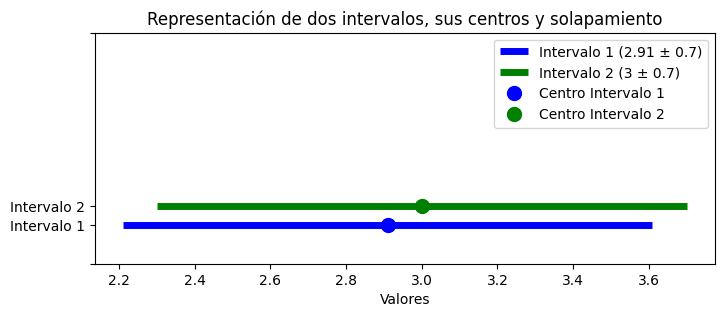

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Definir los intervalos
centro1 = 2.91
rango1 = 0.7
centro2 = 3
rango2 = rango1

# Definir los extremos de los intervalos
intervalo1 = [centro1 - rango1, centro1 + rango1]
intervalo2 = [centro2 - rango2, centro2 + rango2]

# Crear un gráfico
plt.figure(figsize=(8, 3))

# Dibujar los intervalos como líneas horizontales
plt.hlines(1, intervalo1[0], intervalo1[1], colors='blue',  label=f'Intervalo 1 ({centro1} ± {rango1})', linewidth=5)
plt.hlines(1.1, intervalo2[0], intervalo2[1], colors='green', label=f'Intervalo 2 ({centro2} ± {rango2})', linewidth=5)
plt.plot(centro1, 1, 'bo', markersize=10, label='Centro Intervalo 1')
plt.plot(centro2, 1.1, 'go', markersize=10, label='Centro Intervalo 2')


# Añadir etiquetas y leyenda
plt.xlabel('Valores')
plt.yticks([0.8,1, 1.1,2], ['','Intervalo 1', 'Intervalo 2',''])
plt.legend()
plt.title('Representación de dos intervalos, sus centros y solapamiento')

# Mostrar el gráfico
plt.show()



Visto así, no parece que el incremento de ventas sea algo que podamos dar por sentado. Pero, ¿cómo determinar estos intervalos de confianza? Vamos a ver varias alternativas


- Resultados relacionados con la distribución concreta, como veremos en el caso de la normal con la ley empírica
- Teorema del límite central y alternativas como _bootstrapping_
- Mediante tests estadísticos (una clase posterior)



## 2. Distribución Normal
---

### 2.1 Definición

<div class="alert alert-success">
La distribución normal o gaussiana, $\mathcal{N(\mu,\sigma)}$ es una distribución continua cuya función de probabilidad viene dada por:

$$f(x) = \frac{1}{\sigma \sqrt{2 \pi}} e^{-\frac{(x - \mu)^2}{2 \sigma^2}}$$
</div>

La fórmula en sí no dice mucho, pero seguro que reconocemos la tradicional forma de "campana". El siguiente ejemplo corresponde a la distribución de probabilidad de la altura de las personas adultas

<img src="https://github.com/RafaelCaballero/tdm/raw/refs/heads/master/images/normal.png" width=600></img>

LA normal viene dada por dos parámetros

- La media, $\mu$, el centro de la distribución
- La desviación típica $\sigma$, cuanto mayor sea más "ancha" y menos "alta" será la distribución

Así que tenemos toda una familia de distribuciones normales. En el siguiente ejemplo tenemos una $\mathcal{N}(20,0.6)$ y una $\mathcal{N}(70,4)$:

<img src="https://github.com/RafaelCaballero/tdm/raw/refs/heads/master/images/normal2.png" width=600></img>

En Python:

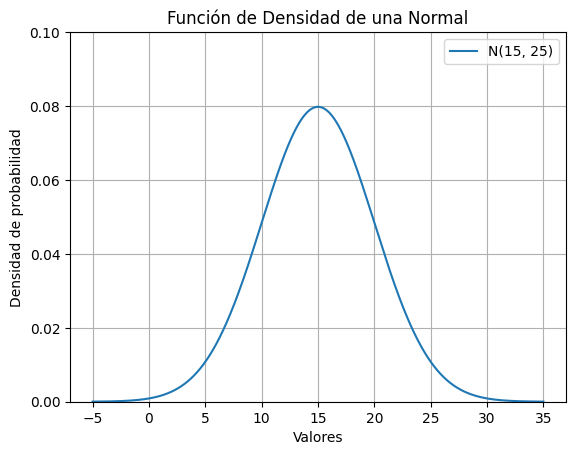

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Parámetros de la normal
media = 15
desviacion_tipica = 5

# Generar valores para el eje X
x = np.linspace(media - 4*desviacion_tipica, media + 4*desviacion_tipica, 1000)

# Calcular la función de densidad (probability distribution function)
y = norm.pdf(x, media, desviacion_tipica)

# Dibujar la función de densidad
plt.plot(x, y, label=f'N({media}, {desviacion_tipica**2})')
plt.ylim(0,0.10)
plt.title('Función de Densidad de una Normal')
plt.xlabel('Valores')
plt.ylabel('Densidad de probabilidad')
plt.legend()
plt.grid(True)
plt.show()


### 2.2 Propiedades:

- En una normal perfecta, media moda y mediana coinciden y son el valor más probable
- Según nos alejamos de la media la probabilidad baja rápidamente (dependerá de la varianza $\sigma$
- Es una distribución simétrica
- Se verifica la llamada _regla empírica_

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/22/Empirical_rule_histogram.svg/1280px-Empirical_rule_histogram.svg.png" width=400> </img>

Que, por cierto, podemos relacionar con nuestros boxplots para calcular outliers

<img src="https://github.com/RafaelCaballero/tdm/raw/refs/heads/master/images/Boxplot_vs_PDF.png" width=600></img>

### 2.3 Aplicaciones

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/8b/Eidechse.1024.jpg/500px-Eidechse.1024.jpg" width=100></img>

La normal surge de natural en muchos fenómenos:

- Al medir la edad de un grupo aleatorio de personas
- Si medimos distintos ejemplares de macho adulto _lagartija ibérica hispánica_
- Número de piezas defectuosas en varias fábricas del mismo tipo
- Resultados de la medida del mismo parámetro mediante muchas muestras obtenidas de la misma población o mediante muchas medidas (teorema central del límite)

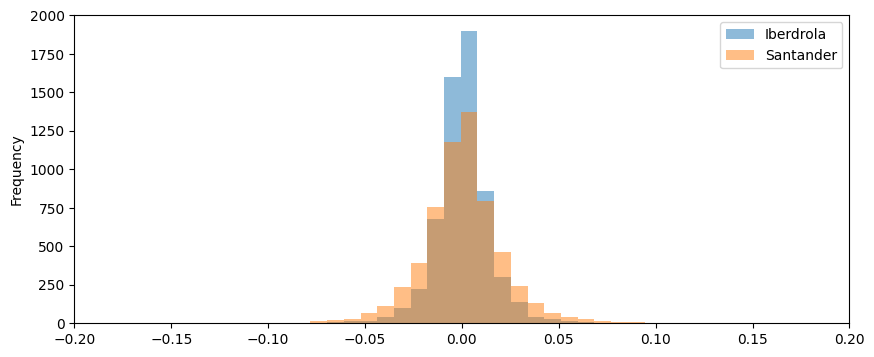

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
url = "https://github.com/RafaelCaballero/tdm/raw/refs/heads/master/datos/IBEX6000Inc.zip"

cols = ["Iberdrola","Santander"]
df_raw = pd.read_csv(url,parse_dates=['Fecha'],index_col='Fecha').dropna()
fig, ax = plt.subplots(figsize=(10, 4),dpi=100)
df_raw[cols].plot(kind="hist", ax=ax,bins=50, alpha=0.5)
plt.xlim(-0.2,0.2)
plt.ylim(0,2000)
plt.show()

In [5]:
media = round(df_raw[cols].mean(),3)
std = round(df_raw[cols].std(),3)
print(f"Aproximamos {cols[0]} ~ N({media.iloc[0]},{std.iloc[0]}), {cols[1]} ~ N({media.iloc[1]},{std.iloc[1]})")

Aproximamos Iberdrola ~ N(0.001,0.015), Santander ~ N(0.0,0.022)


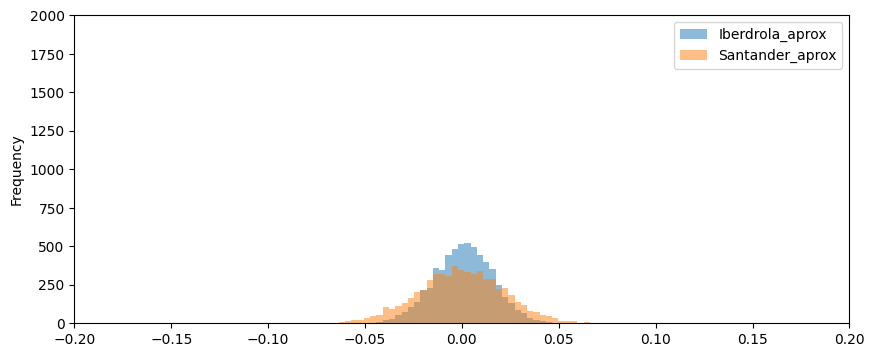

In [6]:
import numpy as np
df_prueba = pd.DataFrame({cols[0]+"_aprox":np.random.normal(media.iloc[0], std.iloc[0], len(df_raw)),
                          cols[1]+"_aprox":np.random.normal(media.iloc[1], std.iloc[1], len(df_raw))})
fig, ax = plt.subplots(figsize=(10, 4),dpi=100)
df_prueba.plot(kind="hist",ax=ax,alpha=0.5,bins=50)
plt.xlim(-0.2,0.2)
plt.ylim(0,2000)
plt.show()

## 3. Simetría y Curtosis
---

La asimetría y la curtosis son medidas que describen características importantes de cualquier distribución de datos, independientemente de si es normal o no. Veamos qué significan ambos conceptos

### 3.1 Simetría

<img src="https://github.com/RafaelCaballero/tdm/raw/refs/heads/master/images/simetria.webp" width=600></img>

Asimetría a la derecha o positiva: muchos datos acumulados en poco espacio a la izquierda, a la derecha un descenso lento y prolongado

* Se tendrá que media>mediana
* Normalmente solo tendremos que preocuparnos por outliers a la derecha, es decir por valores "excesivamente grandes"
* Sucede por ejemplo en mediciones que por su naturaleza son todas positivas --> típico en las variables tipo ratio
* La parte superior de la caja en el boxplot suele ser mayor que la parte inferior (debajo de la mediana)
* Puede tener sentido hacer un estudio diferente a la izquierda y a la derecha de la mediana

Asimetría a la izquierda o negativa: muchos datos acumulados en poco espacio a la derecha, a la izquierda un descenso lento y prolongado



<Axes: ylabel='Frequency'>

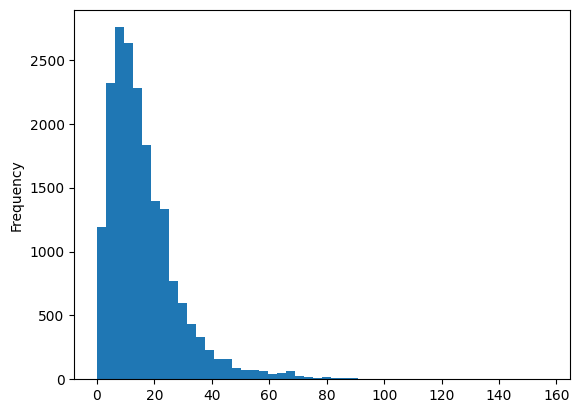

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

url = "https://raw.githubusercontent.com/RafaelCaballero/tdm/master/datos/madrid/contaminacionLargo.csv"
df_conta = pd.read_csv(url)

df_conta.PM10.plot(kind="hist",bins=50)

Text(0.5, 1.0, 'Histograma y Función de Densidad para PM10 con Moda, Media y Mediana')

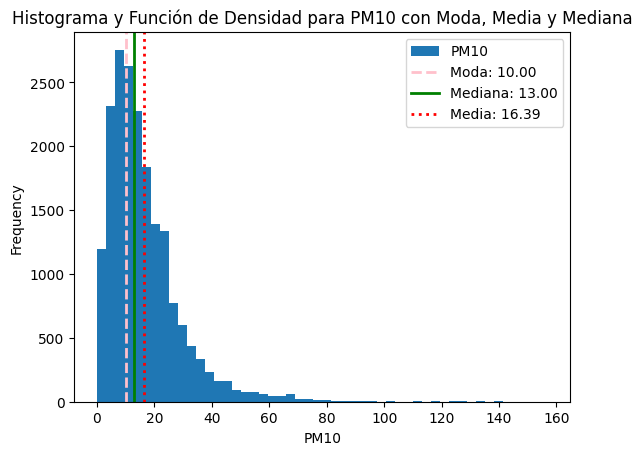

In [8]:

df_conta.PM10.plot(kind="hist",bins=50)
moda = df_conta.PM10.mode().values[0]
media = df_conta.PM10.mean()
mediana = df_conta.PM10.median()
plt.axvline(moda, color='pink', linestyle='dashed', linewidth=2, label=f'Moda: {moda:.2f}')
plt.axvline(mediana, color='green', linestyle='solid', linewidth=2, label=f'Mediana: {mediana:.2f}')
plt.axvline(media, color='red', linestyle='dotted', linewidth=2, label=f'Media: {media:.2f}')
plt.legend()
plt.xlabel('PM10')
plt.title('Histograma y Función de Densidad para PM10 con Moda, Media y Mediana')


<Axes: >

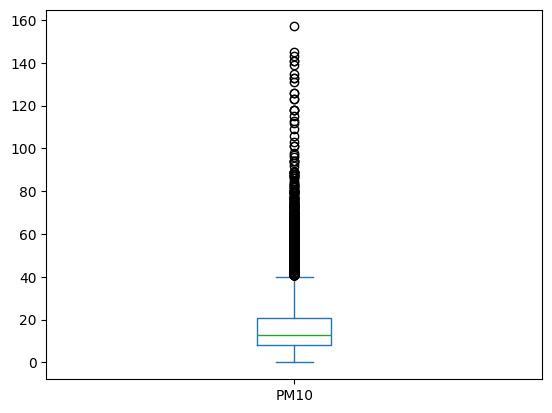

In [9]:
df_conta.PM10.plot(kind="box")

Lo primero poder detectar la asimetría de una forma que no sea "visual". Para esto tenemos la función `skew` de Pandas nos indica la asimetría:

        >0 : Asimetría a la derecha o positiva
        aprox. 0 : simétrico
        <0 : asimetría a la izquierda o negativa

In [10]:
df_conta.PM10.skew()

np.float64(2.404078728714794)

In [11]:
url = "https://github.com/RafaelCaballero/tdm/raw/refs/heads/master/datos/IBEX6000Inc.zip"

# solución
df_raw = pd.read_csv(url,parse_dates=['Fecha']).dropna()
col = "Iberdrola"
df_raw[cols].skew()

,0
Iberdrola,0.336693
Santander,0.245350


La segunda parte sería intentar detectar outliers. Un método posible para esto es

a) Modificar la columna para convertirla en "simétrica", con métodos como Box-Cox o Yeo-Johnson

b) Encontrar outliers en la columna transformada

<Axes: >

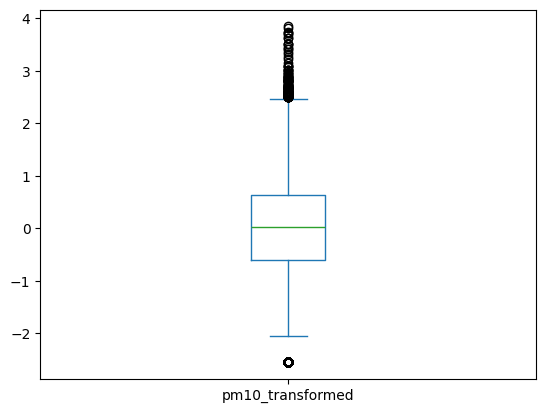

In [12]:
from sklearn.preprocessing import PowerTransformer
import pandas as pd

# Cargar datos
url = "https://raw.githubusercontent.com/RafaelCaballero/tdm/master/datos/madrid/contaminacionLargo.csv"
df_conta = pd.read_csv(url).dropna()

# Seleccionar la columna PM10, la convertimos a  -1, +1 para que esté centrada en el 0
pm10 = df_conta['PM10'].values.reshape(-1, 1)

# Aplicar la transformación de Yeo-Johnson
pt = PowerTransformer(method='yeo-johnson')
df_conta["pm10_transformed"] = pt.fit_transform(pm10)
df_conta["pm10_transformed"].plot(kind="box")

<Axes: ylabel='Frequency'>

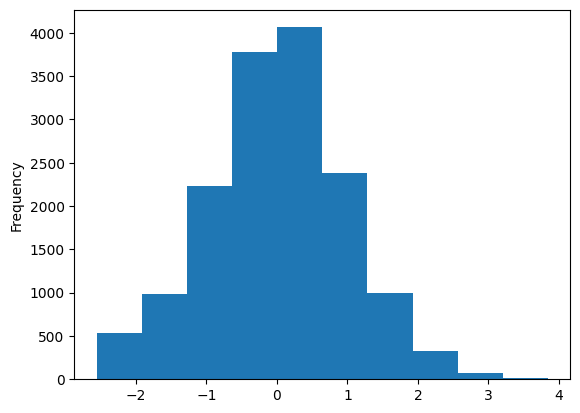

In [13]:
df_conta["pm10_transformed"].plot(kind="hist")

In [14]:
# detecta outliers a la derecha en un columna de un dataframe usando el mismo método que los boxplots)
def pos_outliers(df,col):
    pm10 = df[col].dropna()

    # Calcular cuartiles y rango intercuartílico
    Q1 = pm10.quantile(0.25)
    Q3 = pm10.quantile(0.75)
    IQR = Q3 - Q1

    # Ajustar el multiplicador para el rango intercuartílico (por ejemplo, 0.5 en lugar de 1.5)
    upper_bound = Q3 + 0.5 * IQR

    # Filtrar los outliers
    outliers = pm10[(pm10 > upper_bound)]
    return outliers


total = len(df_conta["PM10"].dropna())
o1 = pos_outliers(df_conta,"PM10")
o2 = pos_outliers(df_conta,"pm10_transformed")
print(f"Proporción de outliers en PM10: {len(o1)/total:.2f} PM10 Trans: {len(o2)/total:.2f}")

Proporción de outliers en PM10: 0.15 PM10 Trans: 0.10


### 3.2 Curtosis


La curtosis indica el peso de las colas en relación con una normal estándar. A menudo se confunde con "apuntamiento" pero no es exactamente lo mismo. La función `kurtosis` de Pandas nos indica este valor:

        >0 : leptocúrtica ; los outliers tienen más peso que en la normal, tenemos muchos outliers (hay que ver por qué y si merece la pena hacer un estudio solo de esta parte)
        aprox. 0 : mesocúrtica, similar a una normal
        <0 : platicúrtica, los outliers tienen menos peso que en la normal, la distribución está más concentrada alrededor de la media

<img src="https://github.com/RafaelCaballero/tdm/raw/refs/heads/master/images/curtosis.jpg" width=300></img>

In [15]:
df_raw[cols].kurtosis()

,0
Iberdrola,13.759286
Santander,8.161803


In [16]:
df_prueba.kurtosis()

,0
Iberdrola_aprox,-0.056256
Santander_aprox,0.061864


Una curtosis o una asimetría muy alejadas de 0 indicarán que la distribución se aleja de la normal, pero la regla empírica es bastante "robusta":

In [17]:

for c in cols:
  media = df_raw[c].mean()
  desv  = df_raw[c].std()
  filtro = ((df_raw[c])>(media-2*desv)) & ((df_raw[c])<(media+2*desv))
  print(f"{c} -> % en el intervalo [media-2std, media+2std]: {filtro.mean()*100:.5f}%")

Iberdrola -> % en el intervalo [media-2std, media+2std]: 95.40000%
Santander -> % en el intervalo [media-2std, media+2std]: 94.98333%


## 4. Teorema central del límite
---

### 4.1 Definición

Sea $S_1, S_2, \dots, S_n$ un conjunto de muestras aleatorias independientes e idénticamente distribuidas, la distribución de la  medias de cada muestra sigue una distribución normal, con media la media de la distribución de la que están tomadas las muestras, y desviación típica ${\sigma / \sqrt{n}}$ con $\sigma$ la desviación típica de la muestra original

$\bar{X} \sim \mathcal{N}\left(\mu, \frac{\sigma^2}{n}\right)$

Es decir, al tomar muestras, aunque la variable no siga una distribución normal las medias de las muestras sí lo hacen ¿Por qué? Porque hemos dicho que al tomar medidas repetidamente los valores siguen una normal...¡las muestras son nuestras lagartijas!

<img src="https://github.com/RafaelCaballero/tdm/raw/refs/heads/master/images/lagartija_gauss.webp" width=200></img>

Una simulación de dos distribuciones

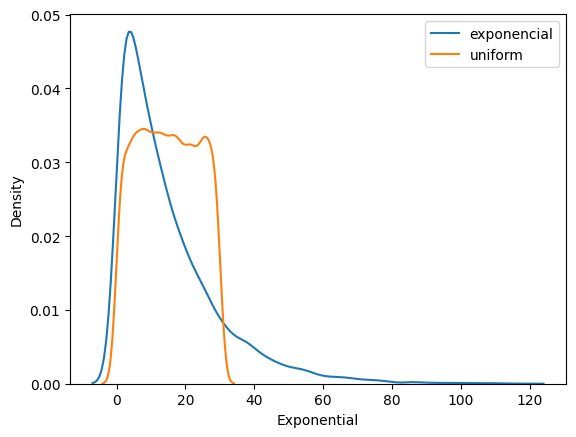

Medias Uniform        14.978081
Exponential    15.010409
dtype: float64


In [18]:
import numpy as np
import pandas as pd


n_values = 10000
mean_uniform = 15
mean_exponential = 15

# centrada en 15
range_width = 30
a = mean_uniform - range_width / 2
b = mean_uniform + range_width / 2
uniform_values = np.random.uniform(low=a, high=b, size=n_values)

# Generar distribución exponencial con media 15
exponential_values = np.random.exponential(scale=mean_exponential, size=n_values)

# Crear el DataFrame
df = pd.DataFrame({
    'Uniform': uniform_values,
    'Exponential': exponential_values
})
import seaborn as sns

sns.kdeplot(df.Exponential,label="exponencial")
sns.kdeplot(df.Uniform,label="uniform")
plt.legend()
plt.show()
print("Medias",df.mean())

100%|██████████| 10000/10000 [00:04<00:00, 2410.18it/s]


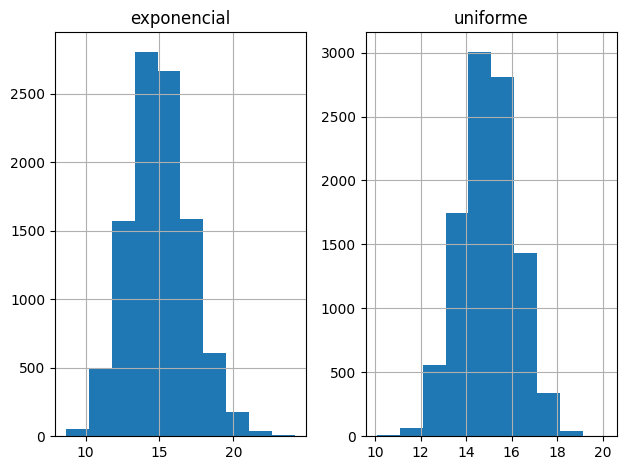

medias
 exponencial    15.000053
uniforme       14.984454
dtype: float64
dev.típica
 exponencial    2.086207
uniforme       1.224639
dtype: float64
curtosis:
 Uniform       -1.189802
Exponential    4.959320
dtype: float64
Asimetría:
 Uniform        0.018754
Exponential    1.893439
dtype: float64


In [19]:
from tqdm import tqdm
def medias(c,veces=10000,s=50):
    medias = []
    for i in tqdm(range(veces)):
        medias.append(c.sample(s).mean())
    return medias

df_medias = pd.DataFrame({"exponencial": medias(df.Exponential) , "uniforme": medias(df.Uniform)})
df_medias.hist()
plt.tight_layout()
plt.show()
print("medias\n",df_medias.mean())
print("dev.típica\n",df_medias.std())
print("curtosis:\n",df.kurtosis())
print("Asimetría:\n",df.skew())


### 4.2 Aplicación

<div class="alert alert-success">
Ley Empírica de la Normal + Teorema Central del límite  = Intervalo de confianza para la media
</div>

Queremos comparar el incremento en bolsa de BBVA de jueves y viernes con respecto al día anterior


In [20]:
import pandas as pd
url = "https://github.com/RafaelCaballero/tdm/raw/refs/heads/master/datos/IBEX6000Inc.zip"

# solución
df_raw = pd.read_csv(url,parse_dates=['Fecha']).dropna()

filtroJ = df_raw["Día"] == "Jueves"
filtroV = df_raw["Día"] == "Viernes"

df_raw[filtroJ].BBVA.mean()*100, df_raw[filtroV].BBVA.mean()*100

(np.float64(0.07047185430463576), np.float64(0.033937605396290045))

¿Es significativa este diferencia?

Hay dos formas de hacerlo

1) Aplicar directamente el teorema, es decir utilizar
$$\overline{x} \pm  Z \frac{s}{\sqrt{n}}$$

 con
 - $\overline{x}$ la media de la columna
 - $s$ su desviación típica
 - Z valor crítico de la distribución normal estándar correspondiente al nivel de confianza deseado, por ejemplo para un 95% tomaríamos

$$\overline{x} \pm  1.96 \frac{s}{\sqrt{n}}$$

Este método es una primera aproximación, pero funciona pero para distribuciones muy asimétricas o sesgadas. En neustro caso como son casi normales sí que va muy bien.

In [21]:
import math
def calculaCI(c,z=1.96):
  x = c.mean()
  s = c.std()
  n = len(c)
  return x,[x-z*s/math.sqrt(n),x+z*s/math.sqrt(n)]

xJ, intervaloJ = calculaCI(df_raw[filtroJ].BBVA.dropna()*100)
xV, intervaloV = calculaCI(df_raw[filtroV].BBVA.dropna()*100)
print(f"Jueves. Media {xJ}, IC: {intervaloJ}")
print(f"Viernes. Media {xV}, IC: {intervaloV}")

Jueves. Media 0.07047185430463576, IC: [np.float64(-0.05163327437906301), np.float64(0.19257698298833453)]
Viernes. Media 0.03393760539629007, IC: [np.float64(-0.08878282036035912), np.float64(0.15665803115293925)]


2) Hacemos muchas muestras de tamaño pequeño (menos del 10% de la población), calculando en cada una la media. El resultado serán medias que siguen una normal, ahí podremos por un lado calcular la media de esas medias y por otra obtener el intervalo de confianza mediante la regla empírica de la normal. Este método es en general más robusto, aunque en ocasiones el intervalo a veces es mayor.

In [22]:
from tqdm import tqdm

# repite reps veces la toma de muestra de tamaño s sobre la columna col_comparar filtrada por col_filtro==vs[0],col_filtro==vs[1],...
def media_samples(df,col_filtro,vs,col_comparar,reps=10000,s=150):
    df_medias = pd.DataFrame()
    for v in vs:
        filtro = df[col_filtro] == v
        c =  df[filtro][col_comparar].dropna()
        medias = []
        tamaño = min([s, c.shape[0]])
        for i in tqdm(range(reps)):
            medias.append( c.sample(tamaño).mean())
        df_medias[v] = medias
    return df_medias

medias = media_samples(df_raw,"Día",["Jueves","Viernes"],"BBVA")
medias

100%|██████████| 10000/10000 [00:02<00:00, 4578.65it/s]


,Jueves,Viernes
0,0.000079,0.002528
1,0.001015,0.002088
2,0.000625,0.002388
3,-0.001098,-0.002895
4,-0.000138,-0.000081
...,...,...
9995,0.003491,0.000437
9996,0.004003,-0.001583
9997,0.002873,0.000541
9998,-0.000532,0.002869


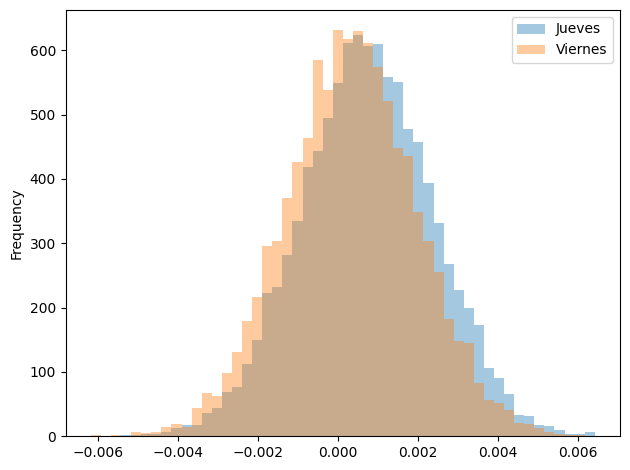

In [23]:
medias.plot(kind="hist",bins=50,alpha=0.4)
plt.tight_layout()
plt.show()

In [24]:
(medias.Jueves.skew(), medias.Jueves.kurtosis()), (medias.Viernes.skew(), medias.Viernes.kurtosis())

((np.float64(-0.015743337348403868), np.float64(0.02353556956323466)),
 (np.float64(-0.013624420272631046), np.float64(0.078148758883684)))

Es una buena aproximación a una normal; esto nos permite calcular la "regla empírica": tenemos un 95% de posibilidades de que el valor real de la media este entre $\mu -2\sigma$ y $\mu + 2\sigma$ en ambas distribuciones:


In [25]:
muJ, muV = medias.Jueves.mean(), medias.Viernes.mean()
sigmaJ, sigmaV = medias.Jueves.std(), medias.Viernes.std()

print(f"Jueves : {100*muJ:.4} [{100*(muJ-2*sigmaJ):.4f},{100*(muJ+2*sigmaJ):.4f}]")
print(f"Viernes: {100*muV:.4} [{100*(muV-2*sigmaV):.4f},{100*(muV+2*sigmaV):.4f}]")

Jueves : 0.07351 [-0.2576,0.4046]
Viernes: 0.03298 [-0.2945,0.3605]


In [26]:
días =  df_raw["Día"].dropna().unique()

df_medias =  media_samples(df_raw,"Día",días,"BBVA")


100%|██████████| 10000/10000 [00:02<00:00, 4950.17it/s]


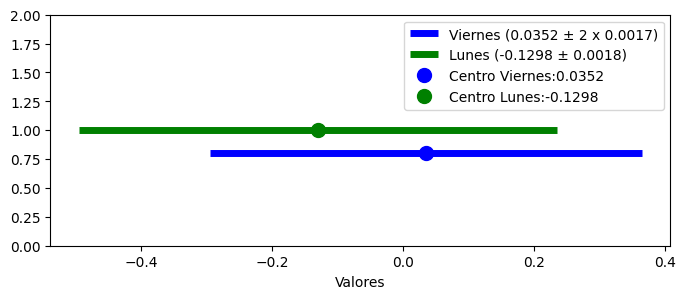

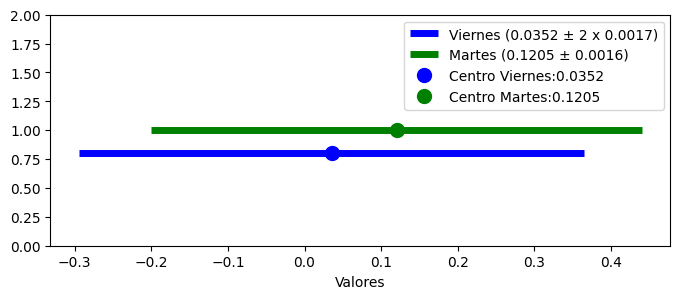

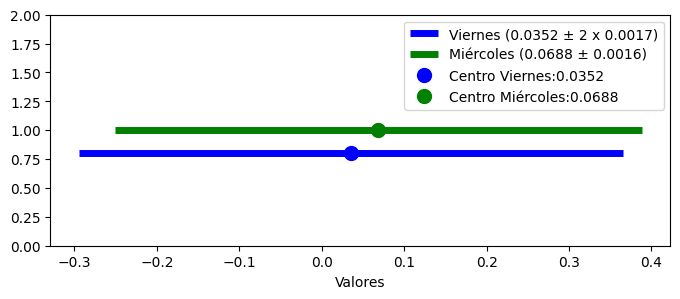

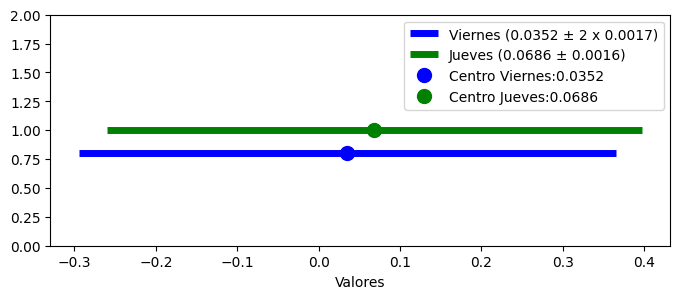

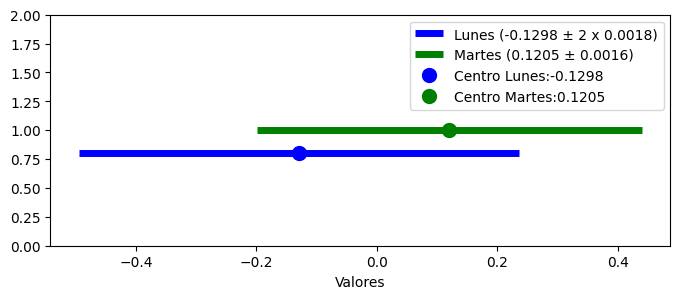

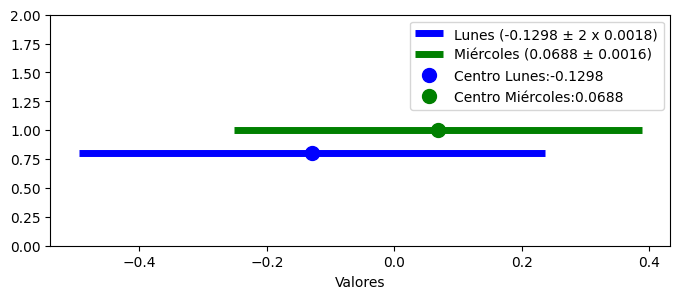

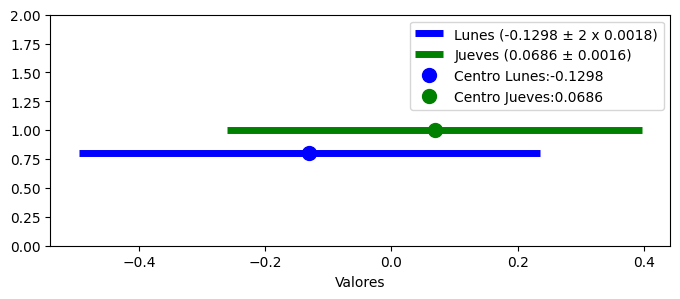

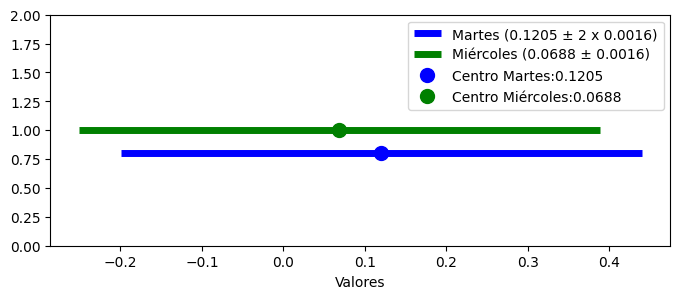

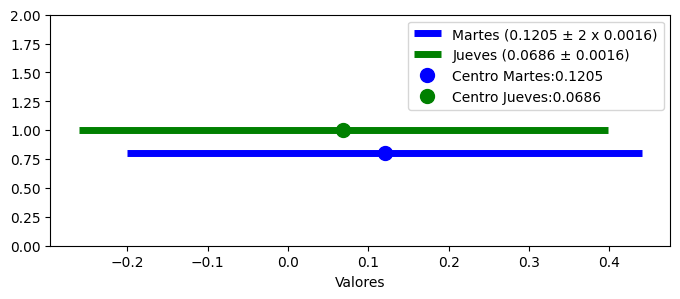

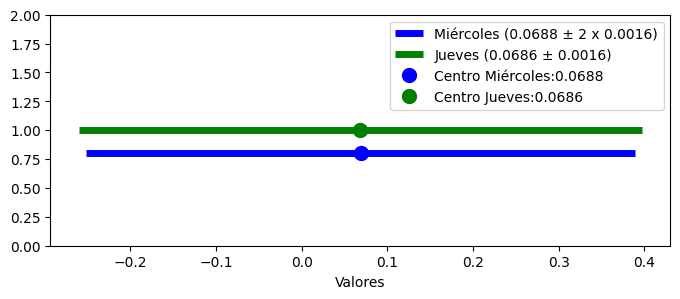

In [27]:
for i in range(len(días)):
    for j in range(i+1,len(días)):
        día1 = días[i]
        día2 = días[j]
        mu1, mu2 = df_medias[día1].mean(), df_medias[día2].mean()
        sigma1, sigma2 = df_medias[día1].std(), df_medias[día2].std()
        limInf1 = 100*(mu1-2*sigma1)
        limInf2 = 100*(mu2-2*sigma2)
        limSup1 = 100*(mu1+2*sigma1)
        limSup2 = 100*(mu2+2*sigma2)
        #print(f"{día1} : {100*mu1:.4} [{limInf1:.4f},{limSup1:.4f}]")
        #print(f"{día2}: {100*mu2:.4} [{limInf2:.4f},{limSup2:.4f}]")
        # Definir los extremos de los intervalos
        intervalo1 = [limInf1, limSup1]
        intervalo2 = [limInf2, limSup2]

        # Crear un gráfico
        plt.figure(figsize=(8, 3))

        # Dibujar los intervalos como líneas horizontales
        plt.hlines(0.8, intervalo1[0], intervalo1[1], colors='blue',  label=f'{día1} ({100*mu1:.4f} ± 2 x {sigma1:.4f})', linewidth=5)
        plt.hlines(1.0, intervalo2[0], intervalo2[1], colors='green', label=f'{día2} ({100*mu2:.4f} ± {sigma2:.4f})', linewidth=5)
        plt.plot(100*mu1, 0.8, 'bo', markersize=10, label=f'Centro {día1}:{100*mu1:.4f}')
        plt.plot(100*mu2, 1.0, 'go', markersize=10, label=f'Centro {día2}:{100*mu2:.4f}')


        # Añadir etiquetas y leyenda
        plt.ylim(0,2)
        plt.xlabel('Valores')
        plt.legend()
        #plt.title('Representación de dos intervalos, sus centros y solapamiento')

        # Mostrar el gráfico
        plt.show()


No podemos garantizar diferencias con este método.

Hay que indicar que no solo la media se puede calcular con este método; otros parámetros pueden ser:

- Proporciones en variables discretas, para ver si se puede asegurar que alguno de los valores se repite más que otro
- Sumas de valores
- Medianas, percentiles, aunque pueden requerir más iteraciones especialmente en distribuciones muy asimétricas

Para otros parámetros, o para una estimación más precisa de estos mismos usaremos bootstrapping

## 5. Distribución Binomial y Multinomial
---

### 5.1. Distribución Binomial

Si la columna que estamos examinando sigue una distribución binomial $Bin(n,p)$

$[\hat{p} - Z \cdot SE, \hat{p} + Z \cdot SE]$, donde $\hat{p}$ es la media o proporción de la columna, como hasta ahora, $Z$ es el valor que queremos para la certidumbre estadística (Z=1.96 para el 95% de certidumbre) y

$$SE = \sqrt{\frac{\hat{p}(1 - \hat{p})}{n}}$$

con $n$ el número total de elementos en la columna

### 5.2 Distribución  Multinomial

Si tenemos una columna categórica que toma valores $x_1, x_2, \dots x_k$, podemos imaginar cada fila como un "experimento" en el que se ha seleccionado uno de los valores. Si el número total de filas es suficientemente grande el teorema central del límite también se aplica aquí, cada elemento es como una "medición" y se puede demostrar que en este caso que  de $x_i$, $\hat{p}_i$,está en el intervalo de confianza

$\left[p_i-Z \cdot \sqrt{\frac{p_i (1 - p_i)}{n}},\  p_i+Z \cdot \sqrt{\frac{p_i (1 - p_i)}{n}}\right]$

Donde:

- $n$ es el número de valores (filas)
- $p_i$ es la proporción del valor $i$, es decir nuestra estimación del valor real $\hat{p}_i$
- $Z$ es el número de desviaciones típicas que requiera nuestro nivel de confianza según la regla empírica de la normal, así para el 95% tendremos $Z=1.96$.

Nota: este método solo debe emplearse para valores de $n$ suficientemente grandes y que los $p_i$ no sean muy cercanos ni a 0, ni a 1, como regla aproximada suele pedirse que

- $n\times p_i \geq 5$  
- $n \times (1−p_i) \geq 5$

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

url = "https://raw.githubusercontent.com/RafaelCaballero/tdm/refs/heads/master/datos/olivos.csv"

# lectura
df = pd.read_csv(url)

col = df.ACEITUNA.dropna()
pis = col.value_counts(normalize=True).sort_index()
n = len(col)
pis

,proportion
ACEITUNA,
Hojiblanca,0.339785
Manzanilla,0.220430
Picual,0.439785


In [29]:
n

930

In [30]:
# condiciones
print("n x p_i>=5:", all(n*pis>=5))
print("n x (1-p_i)>=5:", all(n*(1-pis)>=5))

n x p_i>=5: True
n x (1-p_i)>=5: True


In [31]:
# IC
import numpy as np
Z = 1.96
ic = Z*np.sqrt(pis*(1-pis)/n)

df_ic = pd.DataFrame({"Aceituna": pis.index, "proporción": pis.values, "ic_lower": (pis-ic).values, "ic_upper": (pis+ic).values})
df_ic

,Aceituna,proporción,ic_lower,ic_upper
0,Hojiblanca,0.339785,0.309344,0.370226
1,Manzanilla,0.220430,0.193787,0.247073
2,Picual,0.439785,0.407883,0.471687


Text(0, 0.5, 'frecuencia')

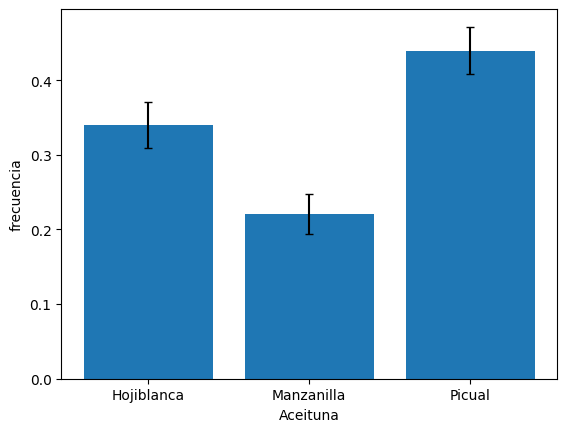

In [32]:
# import package
import matplotlib.pyplot as plt

plt.bar(x=pis.index, height=pis.values, yerr=ic, capsize=3)
plt.xlabel('Aceituna')
plt.ylabel('frecuencia')

## 6. Bootstrapping
---

Si la distribución no es una multinomial, es decir, si no es una var. discreta, bootstrapping es de los mejores métodos:

- Muy robusto, no hace suposiciones (puede ser muy asimétrica, puede ser $n$ pequeño....)
- Da buenos intervalos

A partir del método anterior, la técnica conocida como bootstrapping busca intervalos de confianza no solo para la media sino para otros estadísticos como desviación típica, etc.

Ventajas:

- Utiliza muestras con reemplazamiento --> es adecuado para dataframes con pocos datos
- Otros métodos como el de los percentiles en lugar de la ley empírica --> Intervalos de confianza a veces más precisos

In [33]:
import pandas as pd
import numpy as np


# filtramos para el día deseado
filtro = df_raw["Día"] == "Jueves"

# Seleccionar la columna sin nulos
bbva = df_raw[filtro]["BBVA"].dropna()*100

# Parámetros para bootstrap
n_iterations = 10000  # Número de iteraciones
n_size = len(bbva)  # Tamaño de las muestras bootstrap, pueden ser todos los valores

# Almacenar las medias y desviaciones de cada muestra bootstrap
bootstrap_means = []
bootstrap_stds = []

# Realizar bootstrap
for i in tqdm(range(n_iterations)):
    # Crear una muestra bootstrap
    sample = bbva.sample(replace=True,n=n_size)

    # Calcular la media y la desviación típica de la muestra
    bootstrap_means.append(sample.mean())
    bootstrap_stds.append(sample.std())

# Calcular los intervalos de confianza (por ejemplo, al 95%)
confidence_level = 95
lower_mean = np.percentile(bootstrap_means, (100 - confidence_level) / 2)
upper_mean = np.percentile(bootstrap_means, confidence_level + (100 - confidence_level) / 2)

lower_std = np.percentile(bootstrap_stds, (100 - confidence_level) / 2)
upper_std = np.percentile(bootstrap_stds, confidence_level + (100 - confidence_level) / 2)

print(f"Jueves Media: { np.array(bootstrap_means).mean():.4f} [{lower_mean:.4f},{upper_mean:.4f}]")
print(f"Jueves std: {np.array(bootstrap_stds).mean():.4f} [{lower_std:.4f},{upper_std:.4f}]")



100%|██████████| 10000/10000 [00:02<00:00, 4007.00it/s]

Jueves Media: 0.0710 [-0.0520,0.1935]
Jueves std: 2.1635 [2.0117,2.3303]


Resultado anterior:

Jueves : 0.07139 [-0.2586,0.4014]

In [34]:
import pandas as pd
from scipy.stats import bootstrap
import numpy as np

filtro = df_raw["Día"] == "Jueves"
# columna sin nulos
bbva = df_raw[filtro]["BBVA"].dropna()*100

res = bootstrap((bbva,), np.mean, confidence_level=0.95,n_resamples=10000, method='percentile')
ci = res.confidence_interval

print(f"Jueves Media: { ci.low + (ci.high-ci.low)/2:.4f} [{ci.low:.4f},{ci.high:.4f}]")



Jueves Media: 0.0708 [-0.0519,0.1935]


Para ver si las medias son diferentes podemos
- Calcular cada media con el int. de confianza y ver si se solapan
- Calcular la diferencia de medias con su int. de confianza --> si el intervalo no incluye al 0 ¡son distintas!


In [35]:
import pandas as pd
import numpy as np
from scipy.stats import bootstrap

def mean_diff(data1, data2):
    return (data1.mean() - data2.mean())

url = "https://github.com/RafaelCaballero/tdm/raw/refs/heads/master/datos/IBEX6000Inc.zip"
# solución
df_raw = pd.read_csv(url,parse_dates=['Fecha']).dropna()

# las dos columnas
filtro = df_raw["Día"] == "Lunes"
lunes = df_raw[filtro]["BBVA"]*100
filtro = df_raw["Día"] == "Martes"
martes = df_raw[filtro]["BBVA"]*100

# Bootstrapping para calcular la diferencia de medias
boot_result = bootstrap((lunes, martes), mean_diff,  confidence_level=0.95)

# Resultados
print(f"Diferencia de medias: {mean_diff(lunes, martes):.4f}")
print(f"Intervalo de confianza al 95%: [{boot_result.confidence_interval.low:.4f},{boot_result.confidence_interval.high:.4f}]")


Diferencia de medias: -0.2518
Intervalo de confianza al 95%: [-0.4292,-0.0749]


Como el intervalo no incluye al 0 la media no puede ser 0, así que son diferentes medias de forma estadísticamente significativa

In [36]:
lunes.mean(), martes.mean(), lunes.mean() - martes.mean()

(np.float64(-0.13026913372582),
 np.float64(0.12154801324503313),
 np.float64(-0.2518171469708531))

Un último aviso: el método de bootstrapping se puede utilizar para calcular no solo la media sino la desviación típica o cualquier otro parámetro que consideremos, pero funcionará mal si el parámetro está relacionado con elementos extremos (máximos, mínimos, contar outliers) ya que estos varían mucho según la muestra

## 7. Teorema de Chevyshev
---
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/8f/%D0%A7%D0%B5%D0%B1%D1%8B%D1%88%D1%91%D0%B2%2C_%D0%9F%D0%B0%D1%84%D0%BD%D1%83%D1%82%D0%B8%D0%B9_%D0%9B%D1%8C%D0%B2%D0%BE%D0%B2%D0%B8%D1%87.jpg/1024px-%D0%A7%D0%B5%D0%B1%D1%8B%D1%88%D1%91%D0%B2%2C_%D0%9F%D0%B0%D1%84%D0%BD%D1%83%D1%82%D0%B8%D0%B9_%D0%9B%D1%8C%D0%B2%D0%BE%D0%B2%D0%B8%D1%87.jpg" width=200></img>

El teorema, también conocido como _desigualdad de Chebyshev_ dice que si tenemos una muestra con una varianza muestral finita $\sigma$ y media $\mu$, entonces para todo $k>1$ se tiene:

$$P\left( |X - \mu| \geq k \sigma \right) \leq \frac{1}{k^2}$$

es decir,  la probabilidad de que una observación se encuentre a más de $𝑘$
 desviaciones estándar de la media es como máximo $\frac{1}{k^2}$. Dicho con otras palabras

$$P\left( |X - \mu| < k \sigma \right) \geq 1 - \frac{1}{k^2}$$

Esto nos da un intervalo de confianza haciendo $\alpha = \frac{1}{k^2}$, es decir $k = \frac{1}{\sqrt{\alpha}}$. Así

- Intervalo del 95% de confianza, $k=\frac{1}{\sqrt{0.05}} = 4.47$, es decir, al menos el 95% de los datos están en el intervalo $[\mu−4.47\sigma,\mu+4.47\sigma]$
- Intervalo del 99% de confianza, $k=\frac{1}{\sqrt{0.01}} = 10$, es decir, al menos el 99% de los datos están en el intervalo $[\mu−10\sigma,\mu+10\sigma]$

<div class="alert alert-danger">
Al no hacer ninguna suposición sobre los datos el teorema de Chevyshev genera intervalos muy grandes, válidos para todos los casos
</div>


## 8. Resumen
---

Reglas básicas para determinar un intervalo de confianza para la media

0) Teorema de Chevyshev. Se puede utilizar siempre:

Al menos el 95% de los datos están en el intervalo $[\mu−4.47\sigma,\mu+4.47\sigma]$, para cualquier distribución con media $\mu$ y desviación típica $\sigma$,

El método más seguro, pero el que peor intervalo nos va a dar; solo es útil si se quiere una absoluta certeza estadística


1)  Si la variables es discreta y toma una cantidad pequeña de valores diferentes y se cumple

- $n\times p_i \geq 5$  
- $n \times (1−p_i) \geq 5$

Donde:

- $n$ es el número de valores (filas)
- $p_i$ es la proporción del valor $i$

Entonces se puede obtener el intervalo

$\left[p_i-Z \cdot \sqrt{\frac{p_i (1 - p_i)}{n}},\  p_i+Z \cdot \sqrt{\frac{p_i (1 - p_i)}{n}}\right]$

donde $Z$ es el número de desviaciones típicas que requiera nuestro nivel de confianza según la regla empírica de la normal, así para el 95% tendremos $Z=1.96$.

Es una aplicación del TCL que "controla" los problemas de ls funciones continuas con los requisitos enunciados anteriormente

2) Si es una variable continua y vemos que no es demasiado asimétricas, no tiene muchas colas largas, etc, o simplemente queremos obtener una estimación rápida y no nos preocupa que no sea excesivamente precisa, aplicar

$$\mu \pm  Z \frac{\sigma}{\sqrt{n}}$$

3) Si se quiere obtener una estimación más robusta e independiente de la distribución, o se quiere analizar la diferencia de medias u otros estimadores --> boootstrapping



## 9. Referencias
---

[Teorema central del límite](https://www.geeksforgeeks.org/central-limit-theorem/?ref=oin_asr1) buena explicación con muchos ejemplos.

[Video sobre el central del límite](https://www.youtube.com/watch?v=YAlJCEDH2uY&ab_channel=StatQuestwithJoshStarmer) en inglés pero muy sencillo y agradable (quitando la canción inicial)

[Cálculo de outliers en datos asimétricos](https://wis.kuleuven.be/stat/robust/papers/2008/outlierdetectionskeweddata-revision.pdf). Artículo (en inglés) que define outliers a partir de la medida [medcouple](https://en.wikipedia.org/wiki/Medcouple) una medida de asimetría robusta frente a outliers<br>

[Bootstrapping](https://cienciadedatos.net/documentos/pystats04-bootstrapping-python) bien explicado, paso a paso<br>
